In [26]:
from dask.distributed import Client
import xarray as xr
import numpy as np
import bottleneck
from datetime import datetime
import os
import rasterio as rio

In [38]:
###### Prefix info ###########
network_name = "California"
minx = -124.980469
miny = 32.509762
maxx = -113.994141
maxy = 42.098222
bbox = {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

startDate = datetime(2016, 1, 1)
endDate = datetime(2021, 9, 30)
currentDate = startDate
SMAPL4_times = ['0130', '0430', '0730', '1030', '1330', '1630', '1930', '2230'] # 3-hourly data
SMAPL4_time = SMAPL4_times[0]

###### PATH ###########
input_path = r"..\1_data"
output_path = r"..\3_data_out"
SMAPL3_path = "SPL3SMP_E"
SMAPL4_path = "SPL4SMGP"
SMAPL4_grid_path = "SMAPL4SMGP_EASEreference"
PET_path = "PET"

## Read data 

### SMAP L4 (precip)

In [32]:
fn = os.path.join(input_path, SMAPL4_path, f'SMAP_L4_SM_gph_{currentDate.strftime("%Y%m%d")}T{SMAPL4_time}00_Vv7032_001_HEGOUT.nc')
if not os.path.exists(fn):
    # Data version is old after 2021-09-30
    fn = os.path.join(input_path, SMAPL4_path, f'SMAP_L4_SM_gph_{currentDate.strftime("%Y%m%d")}T{SMAPL4_time}00_Vv7030_001_HEGOUT.nc')
    if not os.path.exists(fn):
        print(f'File does not exist SMAP_L4_SM_gph_{currentDate.strftime("%Y%m%d")}T{SMAPL4_time}00_Vv703x_001_HEGOUT.nc')
# ds_SMAPL4 = rioxarray.open_rasterio(fn, chunks={'x': 100, 'y': 100})
ds_SMAPL4 = xr.open_dataset(fn, engine="rasterio", chunks={'x': 100, 'y': 100})

# TODO/ISSUE: I need to use engine="rasterio". Otherwise, precipitation variable is not read. This is probably because precipitation variable is stored one level below of all other variables (lat, lon, etc.)
# TODO/ISSUE: Y axis is read upside down, so I need to reset the index 
# ds_SMAPL4 = ds_SMAPL4.reindex(y=ds_SMAPL4.y*(-1))
# But If I do this now, the chunking over the y axis disappers. 

ds_SMAPL4

c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.Dataset>
Dimensions:                           (band: 1, x: 3856, y: 1822)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -180.0 -179.9 ... 179.9 180.0
  * y                                 (y) float64 85.0 84.9 ... -84.92 -85.01
    projection_information            int32 ...
Data variables:
    cell_column                       (band, y, x) float64 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    cell_lat                          (band, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    cell_lon                          (band, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    cell_row                          (band, y, x) float64 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    precipitation_total_surface_flux  (band, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            JPL CL#14-2285, JPL 400-1567
    publicationDate:                    2014-07-01
    title:                              SMAP Handbook
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

In [33]:
ds_SMAPL4.precipitation_total_surface_flux

<xarray.DataArray 'precipitation_total_surface_flux' (band: 1, y: 1822, x: 3856)>
dask.array<open_dataset-08ad9642ee4de105d3d7891b44dd3a25precipitation_total_surface_flux, shape=(1, 1822, 3856), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * band                    (band) int32 1
  * x                       (x) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * y                       (y) float64 85.0 84.9 84.81 ... -84.83 -84.92 -85.01
    projection_information  int32 ...
Attributes: (12/17)
    /Geophysical_Data/precipitation_total_surface_flux#coordinates:       /ce...
    /Geophysical_Data/precipitation_total_surface_flux#DIMENSION_LABELS:  {y,x}
    /Geophysical_Data/precipitation_total_surface_flux#fmissing_value:    -9999
    /Geophysical_Data/precipitation_total_surface_flux#grid_mapping:      pro...
    /Geophysical_Data/precipitation_total_surface_flux#long_name:         Tot...
    /Geophysical_Data/precipitation_total_surface_flux#missing_value:     -9999
    ...                                                                   ...
    DIMENSION_LABELS:                                                     {y,x}
    fmissing_value:                                                       -9999
    long_name:                                                            Tot...
    units:                                                                kg ...
    valid_max:                                                            0.0...
    valid_min:                                                            0

In [39]:
ds_SMAPL4_P_clipped = ds_SMAPL4.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy).copy()
ds_SMAPL4_P_clipped.precipitation_total_surface_flux

# Bbox get preserved even if you clip it

<xarray.DataArray 'precipitation_total_surface_flux' (band: 1, y: 103, x: 118)>
dask.array<getitem, shape=(1, 103, 118), dtype=float32, chunksize=(1, 63, 100), chunktype=numpy.ndarray>
Coordinates:
  * band                    (band) int32 1
  * x                       (x) float64 -125.0 -124.9 -124.8 ... -114.1 -114.0
  * y                       (y) float64 42.05 41.96 41.87 ... 32.72 32.62 32.53
    projection_information  int32 0
Attributes: (12/17)
    /Geophysical_Data/precipitation_total_surface_flux#coordinates:       /ce...
    /Geophysical_Data/precipitation_total_surface_flux#DIMENSION_LABELS:  {y,x}
    /Geophysical_Data/precipitation_total_surface_flux#fmissing_value:    -9999
    /Geophysical_Data/precipitation_total_surface_flux#grid_mapping:      pro...
    /Geophysical_Data/precipitation_total_surface_flux#long_name:         Tot...
    /Geophysical_Data/precipitation_total_surface_flux#missing_value:     -9999
    ...                                                                   ...
    DIMENSION_LABELS:                                                     {y,x}
    fmissing_value:                                                       -9999
    long_name:                                                            Tot...
    units:                                                                kg ...
    valid_max:                                                            0.0...
    valid_min:                                                            0

In [34]:
ds_SMAPL4_P = ds_SMAPL4.precipitation_total_surface_flux
ds_SMAPL4_P.rio.write_crs('epsg:4326', inplace=True)

<xarray.DataArray 'precipitation_total_surface_flux' (band: 1, y: 1822, x: 3856)>
dask.array<open_dataset-08ad9642ee4de105d3d7891b44dd3a25precipitation_total_surface_flux, shape=(1, 1822, 3856), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * band                    (band) int32 1
  * x                       (x) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * y                       (y) float64 85.0 84.9 84.81 ... -84.83 -84.92 -85.01
    projection_information  int32 0
Attributes: (12/17)
    /Geophysical_Data/precipitation_total_surface_flux#coordinates:       /ce...
    /Geophysical_Data/precipitation_total_surface_flux#DIMENSION_LABELS:  {y,x}
    /Geophysical_Data/precipitation_total_surface_flux#fmissing_value:    -9999
    /Geophysical_Data/precipitation_total_surface_flux#grid_mapping:      pro...
    /Geophysical_Data/precipitation_total_surface_flux#long_name:         Tot...
    /Geophysical_Data/precipitation_total_surface_flux#missing_value:     -9999
    ...                                                                   ...
    DIMENSION_LABELS:                                                     {y,x}
    fmissing_value:                                                       -9999
    long_name:                                                            Tot...
    units:                                                                kg ...
    valid_max:                                                            0.0...
    valid_min:                                                            0

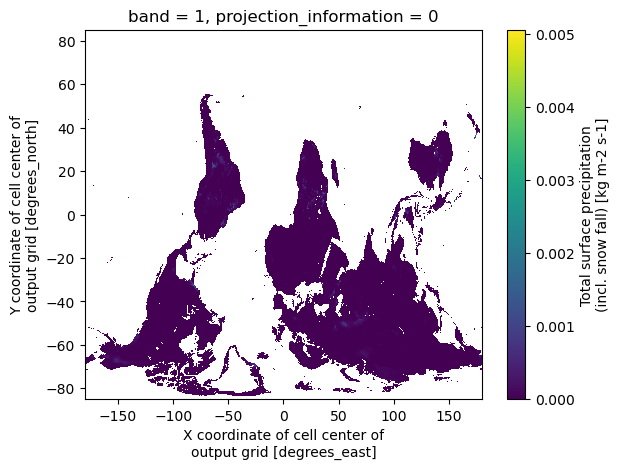

In [35]:
ds_SMAPL4_P.plot()